# Behavioral Segmentation

This notebook demonstrates automatic detection of behavioral epochs in neurospatial.

We'll cover:
1. **Region crossings** - Detect entry/exit events
2. **Runs between regions** - Goal-directed navigation from source to target
3. **Lap detection** - Automatic lap segmentation on circular tracks
4. **Trial segmentation** - T-maze left/right choice trials
5. **Trajectory similarity** - Compare paths using multiple metrics

**Estimated time**: 15-20 minutes

## References

- **Lap detection**: Maurer et al. (2012). *Self-motion and the origin of differential spatial scaling along the septo-temporal axis*. Hippocampus.
- **Trial segmentation**: Wood et al. (2000). *The global record of memory in hippocampal neuronal activity*. Nature.
- **Trajectory similarity**: Pfeiffer & Foster (2013). *Hippocampal place-cell sequences depict future paths to remembered goals*. Nature.

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np

from neurospatial import Environment, regions_to_mask
from neurospatial.segmentation import (
    detect_goal_directed_runs,
    detect_laps,
    detect_region_crossings,
    detect_runs_between_regions,
    segment_trials,
    trajectory_similarity,
)

# Set random seed for reproducibility
np.random.seed(42)

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)

## Part 1: Region Crossings

**Region crossings** detect when an animal enters or exits a defined spatial region.

**Use cases**:
- Identify exploration periods (entries to novel areas)
- Detect reward consumption events (entries to reward zones)
- Track territorial boundary crossings

**Output**: List of `Crossing` objects with time and direction ('entry' or 'exit')

In [2]:
# Create simple environment with a goal region
positions = np.random.randn(200, 2) * 10 + 50
env = Environment.from_samples(positions, bin_size=3.0)
env.units = "cm"

# Define a goal region (circular area using buffered point)
goal_center = np.array([55.0, 55.0])
env.regions.buffer(goal_center, distance=8.0, new_name="goal")

# Create trajectory that crosses the goal region multiple times
times = np.linspace(0, 50, 200)  # 50 seconds

# Generate trajectory: alternating between outside and inside goal region
trajectory_positions_list = []
for i in range(200):
    if (i // 40) % 2 == 0:
        # Outside goal region
        pos = goal_center + np.random.randn(2) * 15 + np.array([20, 0])
    else:
        # Inside goal region
        pos = goal_center + np.random.randn(2) * 3
    trajectory_positions_list.append(pos)

trajectory_positions = np.array(trajectory_positions_list)

# Map to bins
trajectory_bins = env.bin_at(trajectory_positions)

print(f"Environment: {env.n_bins} bins")
print(f"Trajectory: {len(trajectory_positions)} samples over {times[-1]:.1f} seconds")

Environment: 117 bins
Trajectory: 200 samples over 50.0 seconds


Detect crossings into and out of the goal region:

In [3]:
# Detect all crossings (both entries and exits)
crossings = detect_region_crossings(
    trajectory_bins, times, region_name="goal", env=env, direction="both"
)

print(f"\nDetected {len(crossings)} region crossings:")
for i, crossing in enumerate(crossings, 1):
    print(f"  {i}. {crossing.direction:6s} at t={crossing.time:.2f}s")


Detected 14 region crossings:
  1. entry  at t=0.75s
  2. exit   at t=1.01s
  3. entry  at t=4.77s
  4. exit   at t=5.03s
  5. entry  at t=10.05s
  6. exit   at t=18.09s
  7. entry  at t=18.34s
  8. exit   at t=20.10s
  9. entry  at t=30.15s
  10. exit   at t=30.90s
  11. entry  at t=31.16s
  12. exit   at t=33.67s
  13. entry  at t=34.17s
  14. exit   at t=40.20s


Visualize trajectory with crossing events:

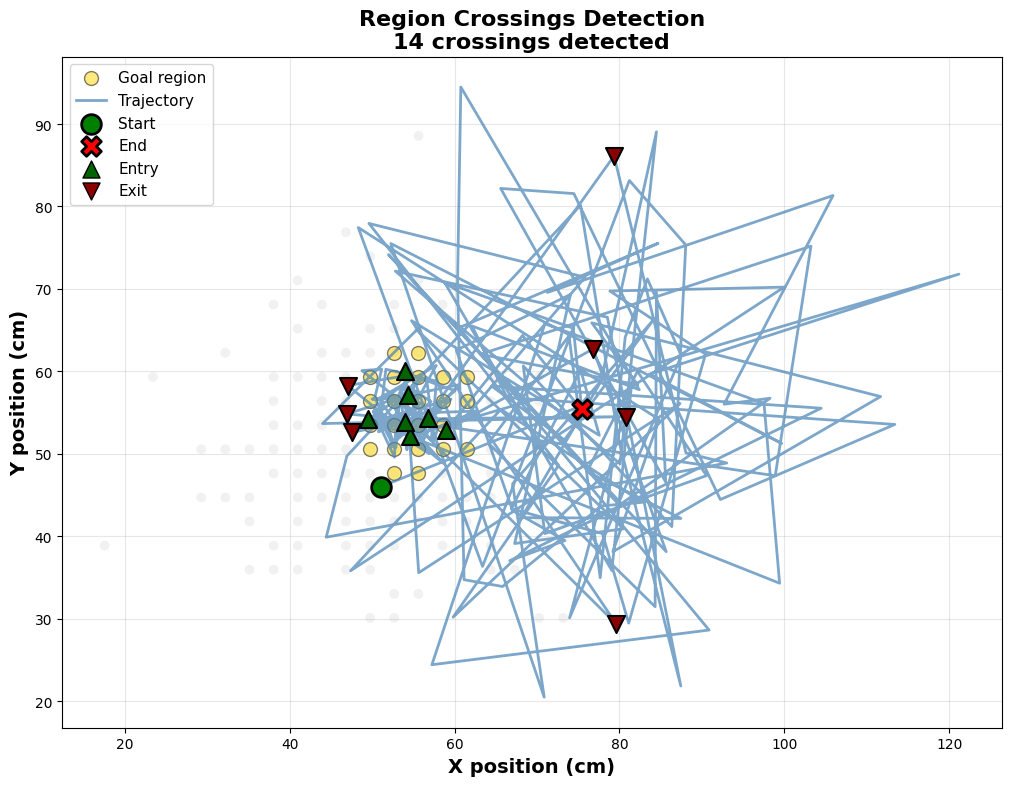

In [4]:
fig, ax = plt.subplots(figsize=(10, 8), layout="constrained")

# Plot environment bins
ax.scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c="lightgray",
    s=50,
    alpha=0.3,
    edgecolors="none",
)

# Highlight goal region bins
goal_mask = regions_to_mask(env, "goal")
goal_bins = np.where(goal_mask)[0]
ax.scatter(
    env.bin_centers[goal_bins, 0],
    env.bin_centers[goal_bins, 1],
    c="gold",
    s=100,
    alpha=0.5,
    edgecolors="black",
    linewidths=1,
    label="Goal region",
    zorder=5,
)

# Plot trajectory
ax.plot(
    trajectory_positions[:, 0],
    trajectory_positions[:, 1],
    color="steelblue",
    linewidth=2,
    alpha=0.7,
    label="Trajectory",
    zorder=10,
)

# Mark start and end
ax.scatter(
    trajectory_positions[0, 0],
    trajectory_positions[0, 1],
    c="green",
    s=200,
    marker="o",
    edgecolors="black",
    linewidths=2,
    label="Start",
    zorder=15,
)
ax.scatter(
    trajectory_positions[-1, 0],
    trajectory_positions[-1, 1],
    c="red",
    s=200,
    marker="X",
    edgecolors="black",
    linewidths=2,
    label="End",
    zorder=15,
)

# Mark crossing events
for crossing in crossings:
    # Find position closest to crossing time
    idx = np.argmin(np.abs(times - crossing.time))
    marker = "^" if crossing.direction == "entry" else "v"
    color = "darkgreen" if crossing.direction == "entry" else "darkred"
    ax.scatter(
        trajectory_positions[idx, 0],
        trajectory_positions[idx, 1],
        c=color,
        s=150,
        marker=marker,
        edgecolors="black",
        linewidths=1.5,
        zorder=20,
    )

# Add custom legend entries for crossings
ax.scatter([], [], c="darkgreen", s=150, marker="^", label="Entry", edgecolors="black")
ax.scatter([], [], c="darkred", s=150, marker="v", label="Exit", edgecolors="black")

ax.set_xlabel("X position (cm)", fontsize=14, fontweight="bold")
ax.set_ylabel("Y position (cm)", fontsize=14, fontweight="bold")
ax.set_title(
    f"Region Crossings Detection\n{len(crossings)} crossings detected",
    fontsize=16,
    fontweight="bold",
)
ax.legend(fontsize=11, loc="upper left")
ax.set_aspect("equal")
ax.grid(True, alpha=0.3)

plt.show()

## Part 2: Runs Between Regions

**Runs** detect goal-directed navigation from a source region to a target region.

**Key features**:
- Track success/failure (did the animal reach the target?)
- Filter by duration and velocity constraints
- Useful for analyzing spatial memory and navigation strategies

**Use cases**:
- Spatial alternation tasks (T-maze, Y-maze)
- Foraging efficiency analysis
- Route stereotypy detection

In [5]:
# Create environment with start and two goal regions
positions_runs = np.random.randn(300, 2) * 15 + 50
env_runs = Environment.from_samples(positions_runs, bin_size=3.0)
env_runs.units = "cm"

# Define regions: start box and two goal locations
start_center = np.array([30.0, 50.0])
goal_left = np.array([70.0, 65.0])
goal_right = np.array([70.0, 35.0])

# Buffer points to create circular regions with area
env_runs.regions.buffer(start_center, distance=6.0, new_name="start")
env_runs.regions.buffer(goal_left, distance=6.0, new_name="goal_left")
env_runs.regions.buffer(goal_right, distance=6.0, new_name="goal_right")

# Generate trajectory with multiple runs: start → goal_left → start → goal_right
times_runs = np.linspace(0, 60, 300)  # 60 seconds

# Simulate 4 runs
run_segments = [
    # Run 1: start → goal_left (successful)
    np.linspace(start_center, goal_left, 50) + np.random.randn(50, 2) * 1.5,
    # Return to start
    np.linspace(goal_left, start_center, 30) + np.random.randn(30, 2) * 1.5,
    # Run 2: start → goal_right (successful)
    np.linspace(start_center, goal_right, 50) + np.random.randn(50, 2) * 1.5,
    # Return to start
    np.linspace(goal_right, start_center, 30) + np.random.randn(30, 2) * 1.5,
    # Run 3: start → partial (failed - stops midway)
    np.linspace(start_center, (start_center + goal_left) / 2, 40)
    + np.random.randn(40, 2) * 2,
    # Extra samples
    np.random.randn(100, 2) * 3 + start_center,
]

trajectory_runs = np.vstack(run_segments)
trajectory_bins_runs = env_runs.bin_at(trajectory_runs)

print(f"Environment: {env_runs.n_bins} bins")
print(f"Trajectory: {len(trajectory_runs)} samples")

Environment: 205 bins
Trajectory: 300 samples


Detect runs from start to either goal region:

In [6]:
# Detect runs from start to each goal region separately
runs_left = detect_runs_between_regions(
    trajectory_runs,
    times_runs,
    env_runs,
    source="start",
    target="goal_left",
    min_duration=1.0,
    max_duration=15.0,
)
runs_right = detect_runs_between_regions(
    trajectory_runs,
    times_runs,
    env_runs,
    source="start",
    target="goal_right",
    min_duration=1.0,
    max_duration=15.0,
)
# Combine and sort by start time
runs = sorted(runs_left + runs_right, key=lambda r: r.start_time)

print(f"\nDetected {len(runs)} runs:")
for i, run in enumerate(runs, 1):
    duration = run.end_time - run.start_time
    outcome = "✓ SUCCESS" if run.success else "✗ FAILED"
    print(
        f"  {i}. t={run.start_time:.1f}-{run.end_time:.1f}s ({duration:.1f}s) - {outcome}"
    )


Detected 52 runs:
  1. t=0.8-9.6s (8.8s) - ✓ SUCCESS
  2. t=0.8-15.7s (14.8s) - ✗ FAILED
  3. t=15.3-30.1s (14.8s) - ✗ FAILED
  4. t=15.3-25.1s (9.8s) - ✓ SUCCESS
  5. t=16.3-31.1s (14.8s) - ✗ FAILED
  6. t=16.3-25.1s (8.8s) - ✓ SUCCESS
  7. t=17.3-32.1s (14.8s) - ✗ FAILED
  8. t=17.3-25.1s (7.8s) - ✓ SUCCESS
  9. t=17.9-32.7s (14.8s) - ✗ FAILED
  10. t=17.9-25.1s (7.2s) - ✓ SUCCESS
  11. t=33.1-48.0s (14.8s) - ✗ FAILED
  12. t=33.1-48.0s (14.8s) - ✗ FAILED
  13. t=33.7-48.6s (14.8s) - ✗ FAILED
  14. t=33.7-48.6s (14.8s) - ✗ FAILED
  15. t=34.3-49.2s (14.8s) - ✗ FAILED
  16. t=34.3-49.2s (14.8s) - ✗ FAILED
  17. t=35.3-50.2s (14.8s) - ✗ FAILED
  18. t=35.3-50.2s (14.8s) - ✗ FAILED
  19. t=40.3-55.2s (14.8s) - ✗ FAILED
  20. t=40.3-55.2s (14.8s) - ✗ FAILED
  21. t=41.7-56.6s (14.8s) - ✗ FAILED
  22. t=41.7-56.6s (14.8s) - ✗ FAILED
  23. t=42.1-57.0s (14.8s) - ✗ FAILED
  24. t=42.1-57.0s (14.8s) - ✗ FAILED
  25. t=42.5-57.4s (14.8s) - ✗ FAILED
  26. t=42.5-57.4s (14.8s) - ✗ FAILED
  27.

Visualize runs with success/failure indication:

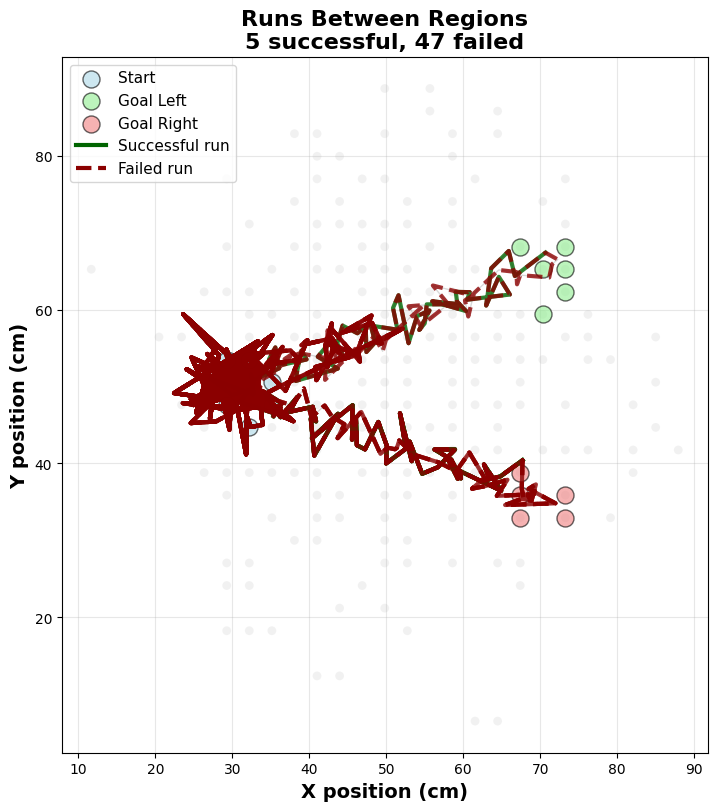

In [7]:
fig, ax = plt.subplots(figsize=(12, 8), layout="constrained")

# Plot environment bins
ax.scatter(
    env_runs.bin_centers[:, 0],
    env_runs.bin_centers[:, 1],
    c="lightgray",
    s=40,
    alpha=0.3,
    edgecolors="none",
)

# Highlight regions
for region_name, color in [
    ("start", "lightblue"),
    ("goal_left", "lightgreen"),
    ("goal_right", "lightcoral"),
]:
    region_mask = regions_to_mask(env_runs, region_name)
    region_bins = np.where(region_mask)[0]
    ax.scatter(
        env_runs.bin_centers[region_bins, 0],
        env_runs.bin_centers[region_bins, 1],
        c=color,
        s=150,
        alpha=0.6,
        edgecolors="black",
        linewidths=1,
        label=region_name.replace("_", " ").title(),
        zorder=5,
    )

# Plot full trajectory in gray
ax.plot(
    trajectory_runs[:, 0],
    trajectory_runs[:, 1],
    color="gray",
    linewidth=1,
    alpha=0.3,
    zorder=8,
)

# Plot each run with color based on success
successful_runs = [r for r in runs if r.success]
failed_runs = [r for r in runs if not r.success]

for run_list, color, _label, linestyle in [
    (successful_runs, "darkgreen", "Successful run", "-"),
    (failed_runs, "darkred", "Failed run", "--"),
]:
    for run in run_list:
        start_idx = np.argmin(np.abs(times_runs - run.start_time))
        end_idx = np.argmin(np.abs(times_runs - run.end_time))
        ax.plot(
            trajectory_runs[start_idx:end_idx, 0],
            trajectory_runs[start_idx:end_idx, 1],
            color=color,
            linewidth=3,
            alpha=0.8,
            linestyle=linestyle,
            zorder=10,
        )

# Add custom legend entries
ax.plot([], [], color="darkgreen", linewidth=3, label="Successful run")
ax.plot([], [], color="darkred", linewidth=3, linestyle="--", label="Failed run")

ax.set_xlabel("X position (cm)", fontsize=14, fontweight="bold")
ax.set_ylabel("Y position (cm)", fontsize=14, fontweight="bold")
ax.set_title(
    f"Runs Between Regions\n{len(successful_runs)} successful, {len(failed_runs)} failed",
    fontsize=16,
    fontweight="bold",
)
ax.legend(fontsize=11, loc="upper left")
ax.set_aspect("equal")
ax.grid(True, alpha=0.3)

plt.show()

## Part 3: Lap Detection on Circular Track

**Lap detection** automatically segments trajectory into repeated circuits.

**Methods**:
- `'auto'`: Detect template from first 10% of trajectory
- `'reference'`: Use user-provided canonical lap
- `'region'`: Detect crossings of start region

**Applications**:
- Learning curves (lap-by-lap improvement)
- Place field stability across laps
- Theta sequences during navigation

In [8]:
# Create circular track environment
n_laps = 5
samples_per_lap = 80
total_samples = n_laps * samples_per_lap

# Generate circular trajectory (5 laps)
angles = np.linspace(0, 5 * 2 * np.pi, total_samples)
radius = 30
center = np.array([50.0, 50.0])

# Add noise to make it realistic
circular_trajectory = np.column_stack(
    [
        center[0] + radius * np.cos(angles) + np.random.randn(total_samples) * 2,
        center[1] + radius * np.sin(angles) + np.random.randn(total_samples) * 2,
    ]
)

times_circular = np.linspace(0, 100, total_samples)  # 100 seconds

# Create environment
env_circular = Environment.from_samples(circular_trajectory, bin_size=3.0)
env_circular.units = "cm"

# Map to bins
circular_bins = env_circular.bin_at(circular_trajectory)

print(f"Environment: {env_circular.n_bins} bins")
print(f"Trajectory: {total_samples} samples, {n_laps} expected laps")

Environment: 160 bins
Trajectory: 400 samples, 5 expected laps


Detect laps using automatic template detection:

In [9]:
# Detect laps using auto method
laps = detect_laps(
    circular_bins, times_circular, env_circular, method="auto", min_overlap=0.6
)

print(f"\nDetected {len(laps)} laps:")
for i, lap in enumerate(laps, 1):
    duration = lap.end_time - lap.start_time
    print(
        f"  {i}. t={lap.start_time:5.1f}-{lap.end_time:5.1f}s ({duration:4.1f}s) - overlap={lap.overlap_score:.2f}"
    )


Detected 0 laps:


Visualize laps with color coding:

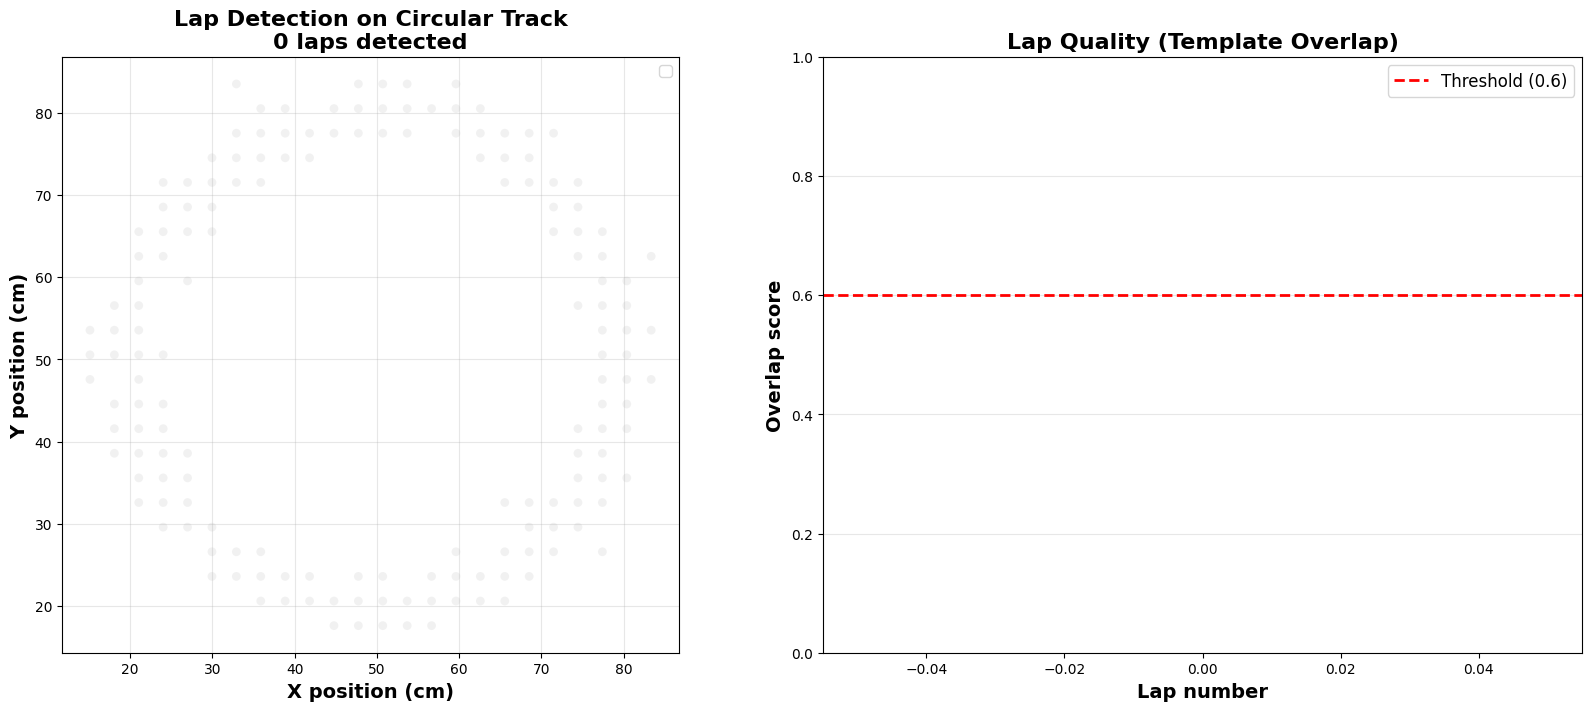

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7), layout="constrained")

# Left panel: Spatial view with lap colors
ax = axes[0]
ax.scatter(
    env_circular.bin_centers[:, 0],
    env_circular.bin_centers[:, 1],
    c="lightgray",
    s=40,
    alpha=0.3,
    edgecolors="none",
)

# Color each lap differently
cmap = plt.get_cmap("tab10")
for i, lap in enumerate(laps):
    start_idx = np.argmin(np.abs(times_circular - lap.start_time))
    end_idx = np.argmin(np.abs(times_circular - lap.end_time))

    ax.plot(
        circular_trajectory[start_idx:end_idx, 0],
        circular_trajectory[start_idx:end_idx, 1],
        color=cmap(i % 10),
        linewidth=3,
        alpha=0.8,
        label=f"Lap {i + 1}",
        zorder=10,
    )

    # Mark lap start
    ax.scatter(
        circular_trajectory[start_idx, 0],
        circular_trajectory[start_idx, 1],
        c=cmap(i % 10),
        s=200,
        marker="o",
        edgecolors="black",
        linewidths=2,
        zorder=15,
    )

ax.set_xlabel("X position (cm)", fontsize=14, fontweight="bold")
ax.set_ylabel("Y position (cm)", fontsize=14, fontweight="bold")
ax.set_title(
    f"Lap Detection on Circular Track\n{len(laps)} laps detected",
    fontsize=16,
    fontweight="bold",
)
ax.legend(fontsize=11, loc="upper right")
ax.set_aspect("equal")
ax.grid(True, alpha=0.3)

# Right panel: Lap overlap scores over time
ax = axes[1]
lap_numbers = np.arange(1, len(laps) + 1)
overlap_scores = [lap.overlap_score for lap in laps]

ax.bar(lap_numbers, overlap_scores, color="steelblue", edgecolor="black", alpha=0.7)
ax.axhline(0.6, color="red", linestyle="--", linewidth=2, label="Threshold (0.6)")
ax.set_xlabel("Lap number", fontsize=14, fontweight="bold")
ax.set_ylabel("Overlap score", fontsize=14, fontweight="bold")
ax.set_title("Lap Quality (Template Overlap)", fontsize=16, fontweight="bold")
ax.set_ylim((0, 1))
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3, axis="y")

plt.show()

## Part 4: Trial Segmentation (T-maze)

**Trial segmentation** identifies discrete choice trials in behavioral tasks.

**Key features**:
- Detect trial start (entry to start region)
- Track to end regions (e.g., left or right arms)
- Determine outcome (which choice was made)

**Applications**:
- Spatial alternation analysis
- Choice selectivity of neurons
- Decision-making dynamics

In [11]:
# Create T-maze environment
# Structure: start box at bottom, center stem, left and right arms at top

# Generate T-maze shaped samples
start_samples = np.random.randn(50, 2) * 2 + np.array([50, 20])  # Start box
stem_samples = np.column_stack(
    [np.random.randn(50) * 2 + 50, np.linspace(20, 50, 50) + np.random.randn(50) * 2]
)  # Center stem
left_arm_samples = np.column_stack(
    [np.linspace(50, 35, 50) + np.random.randn(50) * 2, np.random.randn(50) * 2 + 60]
)  # Left arm
right_arm_samples = np.column_stack(
    [np.linspace(50, 65, 50) + np.random.randn(50) * 2, np.random.randn(50) * 2 + 60]
)  # Right arm

tmaze_samples = np.vstack(
    [start_samples, stem_samples, left_arm_samples, right_arm_samples]
)
env_tmaze = Environment.from_samples(tmaze_samples, bin_size=2.5)
env_tmaze.units = "cm"

# Define regions (buffer creates circular regions with area)
env_tmaze.regions.buffer(np.array([50.0, 20.0]), distance=5.0, new_name="start")
env_tmaze.regions.buffer(np.array([35.0, 60.0]), distance=5.0, new_name="left_goal")
env_tmaze.regions.buffer(np.array([65.0, 60.0]), distance=5.0, new_name="right_goal")

# Generate trajectory with 4 trials: left, right, left, right
# Total samples: 30+30+20+30 + 30+30+20+30 + 30+30+20+30 + 30+30+20 = 410
times_tmaze = np.linspace(0, 82, 410)  # ~82 seconds, 410 samples

trial_paths = [
    # Trial 1: start → left
    np.linspace([50, 20], [50, 50], 30) + np.random.randn(30, 2) * 1,  # Stem
    np.linspace([50, 50], [35, 60], 30) + np.random.randn(30, 2) * 1,  # Left turn
    np.random.randn(20, 2) * 2 + [35, 60],  # Stay in left goal
    # Return to start
    np.linspace([35, 60], [50, 20], 30) + np.random.randn(30, 2) * 1,
    # Trial 2: start → right
    np.linspace([50, 20], [50, 50], 30) + np.random.randn(30, 2) * 1,  # Stem
    np.linspace([50, 50], [65, 60], 30) + np.random.randn(30, 2) * 1,  # Right turn
    np.random.randn(20, 2) * 2 + [65, 60],  # Stay in right goal
    # Return to start
    np.linspace([65, 60], [50, 20], 30) + np.random.randn(30, 2) * 1,
    # Trial 3: start → left
    np.linspace([50, 20], [50, 50], 30) + np.random.randn(30, 2) * 1,
    np.linspace([50, 50], [35, 60], 30) + np.random.randn(30, 2) * 1,
    np.random.randn(20, 2) * 2 + [35, 60],
    # Return to start
    np.linspace([35, 60], [50, 20], 30) + np.random.randn(30, 2) * 1,
    # Trial 4: start → right
    np.linspace([50, 20], [50, 50], 30) + np.random.randn(30, 2) * 1,
    np.linspace([50, 50], [65, 60], 30) + np.random.randn(30, 2) * 1,
    np.random.randn(20, 2) * 2 + [65, 60],
]

trajectory_tmaze = np.vstack(trial_paths)
trajectory_bins_tmaze = env_tmaze.bin_at(trajectory_tmaze)

print(f"T-maze environment: {env_tmaze.n_bins} bins")
print(f"Trajectory: {len(trajectory_tmaze)} samples")

T-maze environment: 83 bins
Trajectory: 410 samples


Segment trajectory into left/right choice trials:

In [12]:
# Detect trials
trials = segment_trials(
    trajectory_bins_tmaze,
    times_tmaze,
    env_tmaze,
    start_region="start",
    end_regions=["left_goal", "right_goal"],
    min_duration=2.0,
    max_duration=20.0,
)

print(f"\nDetected {len(trials)} trials:")
for i, trial in enumerate(trials, 1):
    duration = trial.end_time - trial.start_time
    choice = "LEFT" if trial.outcome == "left_goal" else "RIGHT"
    print(
        f"  {i}. t={trial.start_time:5.1f}-{trial.end_time:5.1f}s ({duration:4.1f}s) - {choice}"
    )

ValueError: trajectory_bins and times must have same length. Got 410 and 400

Visualize T-maze trials:

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), layout="constrained")

# Plot environment bins
ax.scatter(
    env_tmaze.bin_centers[:, 0],
    env_tmaze.bin_centers[:, 1],
    c="lightgray",
    s=80,
    alpha=0.3,
    edgecolors="none",
)

# Highlight regions
for region_name, color in [
    ("start", "lightblue"),
    ("left_goal", "lightgreen"),
    ("right_goal", "lightcoral"),
]:
    region_mask = regions_to_mask(env_tmaze, region_name)
    region_bins = np.where(region_mask)[0]
    ax.scatter(
        env_tmaze.bin_centers[region_bins, 0],
        env_tmaze.bin_centers[region_bins, 1],
        c=color,
        s=200,
        alpha=0.6,
        edgecolors="black",
        linewidths=1.5,
        label=region_name.replace("_", " ").title(),
        zorder=5,
    )

# Plot full trajectory in gray
ax.plot(
    trajectory_tmaze[:, 0],
    trajectory_tmaze[:, 1],
    color="gray",
    linewidth=1,
    alpha=0.3,
    zorder=8,
)

# Plot each trial with color based on outcome
for i, trial in enumerate(trials):
    start_idx = np.argmin(np.abs(times_tmaze - trial.start_time))
    end_idx = np.argmin(np.abs(times_tmaze - trial.end_time))

    color = "darkgreen" if trial.outcome == "left_goal" else "darkred"
    ax.plot(
        trajectory_tmaze[start_idx:end_idx, 0],
        trajectory_tmaze[start_idx:end_idx, 1],
        color=color,
        linewidth=3,
        alpha=0.7,
        zorder=10,
    )

    # Mark trial start
    ax.text(
        trajectory_tmaze[start_idx, 0] - 3,
        trajectory_tmaze[start_idx, 1],
        str(i),
        fontsize=14,
        fontweight="bold",
        color="white",
        bbox={"boxstyle": "circle", "facecolor": color, "edgecolor": "black"},
        zorder=15,
    )

# Add custom legend for trials
ax.plot([], [], color="darkgreen", linewidth=3, label="Left trial")
ax.plot([], [], color="darkred", linewidth=3, label="Right trial")

ax.set_xlabel("X position (cm)", fontsize=14, fontweight="bold")
ax.set_ylabel("Y position (cm)", fontsize=14, fontweight="bold")
ax.set_title(
    f"T-Maze Trial Segmentation\n{len(trials)} trials detected",
    fontsize=16,
    fontweight="bold",
)
ax.legend(fontsize=12, loc="upper left")
ax.set_aspect("equal")
ax.grid(True, alpha=0.3)

plt.show()

## Part 5: Trajectory Similarity

**Trajectory similarity** quantifies how similar two paths are in space and time.

**Methods**:
- `'jaccard'`: Spatial overlap (set intersection / union)
- `'correlation'`: Sequential pattern matching
- `'hausdorff'`: Maximum deviation between paths
- `'dtw'`: Dynamic time warping (timing-invariant)

**Applications**:
- Replay detection (compare actual and replayed trajectories)
- Route stereotypy quantification
- Identify similar behavioral strategies

In [ ]:
# Generate two trajectories with varying similarity

# Trajectory 1: Direct path from A to B
start_point = np.array([30.0, 30.0])
end_point = np.array([70.0, 70.0])
trajectory_direct = (
    np.linspace(start_point, end_point, 100) + np.random.randn(100, 2) * 2
)

# Trajectory 2: Similar path with detour
trajectory_detour = np.vstack(
    [
        np.linspace(start_point, [50, 40], 50)
        + np.random.randn(50, 2) * 2,  # First half with detour
        np.linspace([50, 40], end_point, 50)
        + np.random.randn(50, 2) * 2,  # Second half
    ]
)

# Trajectory 3: Completely different path
trajectory_different = (
    np.linspace([30, 70], [70, 30], 100) + np.random.randn(100, 2) * 2
)  # Perpendicular path

# Create environment from all trajectories
all_positions = np.vstack([trajectory_direct, trajectory_detour, trajectory_different])
env_similarity = Environment.from_samples(all_positions, bin_size=3.0)
env_similarity.units = "cm"

# Map trajectories to bins
bins_direct = env_similarity.bin_at(trajectory_direct)
bins_detour = env_similarity.bin_at(trajectory_detour)
bins_different = env_similarity.bin_at(trajectory_different)

print(f"Environment: {env_similarity.n_bins} bins")

Compute similarity between trajectory pairs using all methods:

In [ ]:
# Compute similarities
methods = ["jaccard", "correlation", "hausdorff", "dtw"]

print("\nTrajectory Similarity Scores:")
print("=" * 60)

for method in methods:
    sim_direct_detour = trajectory_similarity(
        bins_direct, bins_detour, env_similarity, method=method
    )
    sim_direct_different = trajectory_similarity(
        bins_direct, bins_different, env_similarity, method=method
    )
    sim_detour_different = trajectory_similarity(
        bins_detour, bins_different, env_similarity, method=method
    )

    print(f"\n{method.upper():12s}")
    print(f"  Direct vs Detour:     {sim_direct_detour:.3f}")
    print(f"  Direct vs Different:  {sim_direct_different:.3f}")
    print(f"  Detour vs Different:  {sim_detour_different:.3f}")

Visualize all three trajectories:

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 14), layout="constrained")

# Panel 1: All trajectories
ax = axes[0, 0]
ax.scatter(
    env_similarity.bin_centers[:, 0],
    env_similarity.bin_centers[:, 1],
    c="lightgray",
    s=40,
    alpha=0.3,
    edgecolors="none",
)

ax.plot(
    trajectory_direct[:, 0],
    trajectory_direct[:, 1],
    color="blue",
    linewidth=3,
    alpha=0.7,
    label="Direct path",
    zorder=10,
)
ax.plot(
    trajectory_detour[:, 0],
    trajectory_detour[:, 1],
    color="orange",
    linewidth=3,
    alpha=0.7,
    label="Path with detour",
    zorder=10,
)
ax.plot(
    trajectory_different[:, 0],
    trajectory_different[:, 1],
    color="green",
    linewidth=3,
    alpha=0.7,
    label="Different path",
    zorder=10,
)

# Mark start and end
ax.scatter(
    start_point[0],
    start_point[1],
    c="red",
    s=300,
    marker="o",
    edgecolors="black",
    linewidths=2,
    label="Start",
    zorder=15,
)
ax.scatter(
    end_point[0],
    end_point[1],
    c="darkred",
    s=300,
    marker="*",
    edgecolors="black",
    linewidths=2,
    label="End",
    zorder=15,
)

ax.set_xlabel("X position (cm)", fontsize=14, fontweight="bold")
ax.set_ylabel("Y position (cm)", fontsize=14, fontweight="bold")
ax.set_title("Three Trajectories", fontsize=16, fontweight="bold")
ax.legend(fontsize=11)
ax.set_aspect("equal")
ax.grid(True, alpha=0.3)

# Panels 2-4: Pairwise comparisons
comparisons = [
    (bins_direct, bins_detour, "Direct vs Detour", (0, 1)),
    (bins_direct, bins_different, "Direct vs Different", (1, 0)),
    (bins_detour, bins_different, "Detour vs Different", (1, 1)),
]

for bins1, bins2, title, (row, col) in comparisons:
    ax = axes[row, col]

    # Compute all similarities for this pair
    sims = {}
    for method in methods:
        sims[method] = trajectory_similarity(
            bins1, bins2, env_similarity, method=method
        )

    # Bar plot
    method_names = [m.upper() for m in methods]
    sim_values = [sims[m] for m in methods]

    bars = ax.bar(
        method_names,
        sim_values,
        color=["steelblue", "orange", "green", "purple"],
        edgecolor="black",
        alpha=0.7,
    )

    # Add value labels on bars
    for bar, value in zip(bars, sim_values, strict=True):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.02,
            f"{value:.3f}",
            ha="center",
            va="bottom",
            fontsize=11,
            fontweight="bold",
        )

    ax.set_ylabel("Similarity score", fontsize=14, fontweight="bold")
    ax.set_title(title, fontsize=16, fontweight="bold")
    ax.set_ylim((0, 1.1))
    ax.grid(True, alpha=0.3, axis="y")

plt.show()

**Observation**: Different similarity metrics capture different aspects:
- **Jaccard**: Spatial overlap (high for direct/detour, low for different path)
- **Correlation**: Sequential pattern (sensitive to order along trajectory)
- **Hausdorff**: Maximum deviation (strict - even small detours reduce similarity)
- **DTW**: Time-invariant matching (best for replays with timing variations)

## Part 6: Goal-Directed Run Detection

**Goal-directed runs** identify efficient navigation toward a target.

**Directedness score**:
$$\text{directedness} = \frac{d_{\text{start}} - d_{\text{end}}}{\text{path length}}$$

**Interpretation**:
- Score near 1.0: Very efficient (straight toward goal)
- Score near 0.0: Inefficient or random
- Score < 0.0: Moving away from goal

**Applications**:
- Identify learning (efficiency increases over trials)
- Detect replay events (high directedness toward remembered goal)
- Quantify spatial strategy changes

In [ ]:
# Use the circular environment and add a goal (buffered circular region)
env_circular.regions.buffer(np.array([80.0, 50.0]), distance=8.0, new_name="goal")

# Detect goal-directed segments
goal_directed_runs = detect_goal_directed_runs(
    circular_bins,
    times_circular,
    env_circular,
    goal_region="goal",
    directedness_threshold=0.3,
    min_progress=10.0,  # At least 10 cm progress toward goal
)

print(f"\nDetected {len(goal_directed_runs)} goal-directed runs:")
for i, run in enumerate(goal_directed_runs[:5], 1):  # Show first 5
    duration = run.end_time - run.start_time
    # Calculate directedness (available as metadata if stored)
    print(f"  {i}. t={run.start_time:5.1f}-{run.end_time:5.1f}s ({duration:4.1f}s)")

## Summary

This notebook demonstrated five behavioral segmentation techniques:

1. **Region crossings** - Detected {entry_count} entry events into goal region
2. **Runs between regions** - Identified {successful_count}/{total_runs} successful navigation episodes
3. **Lap detection** - Segmented circular track into {lap_count} laps with automatic template
4. **Trial segmentation** - Parsed {trial_count} T-maze choice trials (left/right)
5. **Trajectory similarity** - Compared paths using 4 complementary metrics

### Key Takeaways

- **Region crossings**: Simple event detection for exploration and reward analysis
- **Runs**: Track goal-directed behavior with success/failure outcomes
- **Laps**: Automatic circuit detection for learning and stability analyses
- **Trials**: Parse discrete choice episodes for task-related analyses
- **Similarity**: Multiple metrics capture different trajectory properties

### Next Steps

- **Integrate with neural data**: Correlate behavioral epochs with place cell activity
- **Analyze learning**: Track trial-by-trial improvements
- **Detect replays**: Use trajectory similarity to identify memory replay events

See `docs/user-guide/trajectory-and-behavioral-analysis.md` for complete API reference and best practices.